# Prediction monthly champagne sales

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

[Load data](https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv)

In [84]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv', index_col='Month', parse_dates=True)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 1964-01 to Perrin Freres monthly champagne sales millions ?64-?72
Data columns (total 1 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1)
memory usage: 1.7+ KB


Что вижу: 
- 107 записей и при этом 105 не пустых значения
- index не преобразовался в DateTime как раз из-за пустых строк
- имя столбца неприлично длинное, поменять

In [86]:
df.columns = ['Sales']

In [87]:
df.dropna(inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 1964-01 to 1972-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   105 non-null    float64
dtypes: float64(1)
memory usage: 1.6+ KB


In [89]:
df.index = pd.to_datetime(df.index)

In [90]:
df.index.freq = 'MS'

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   105 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


Теперь все ок

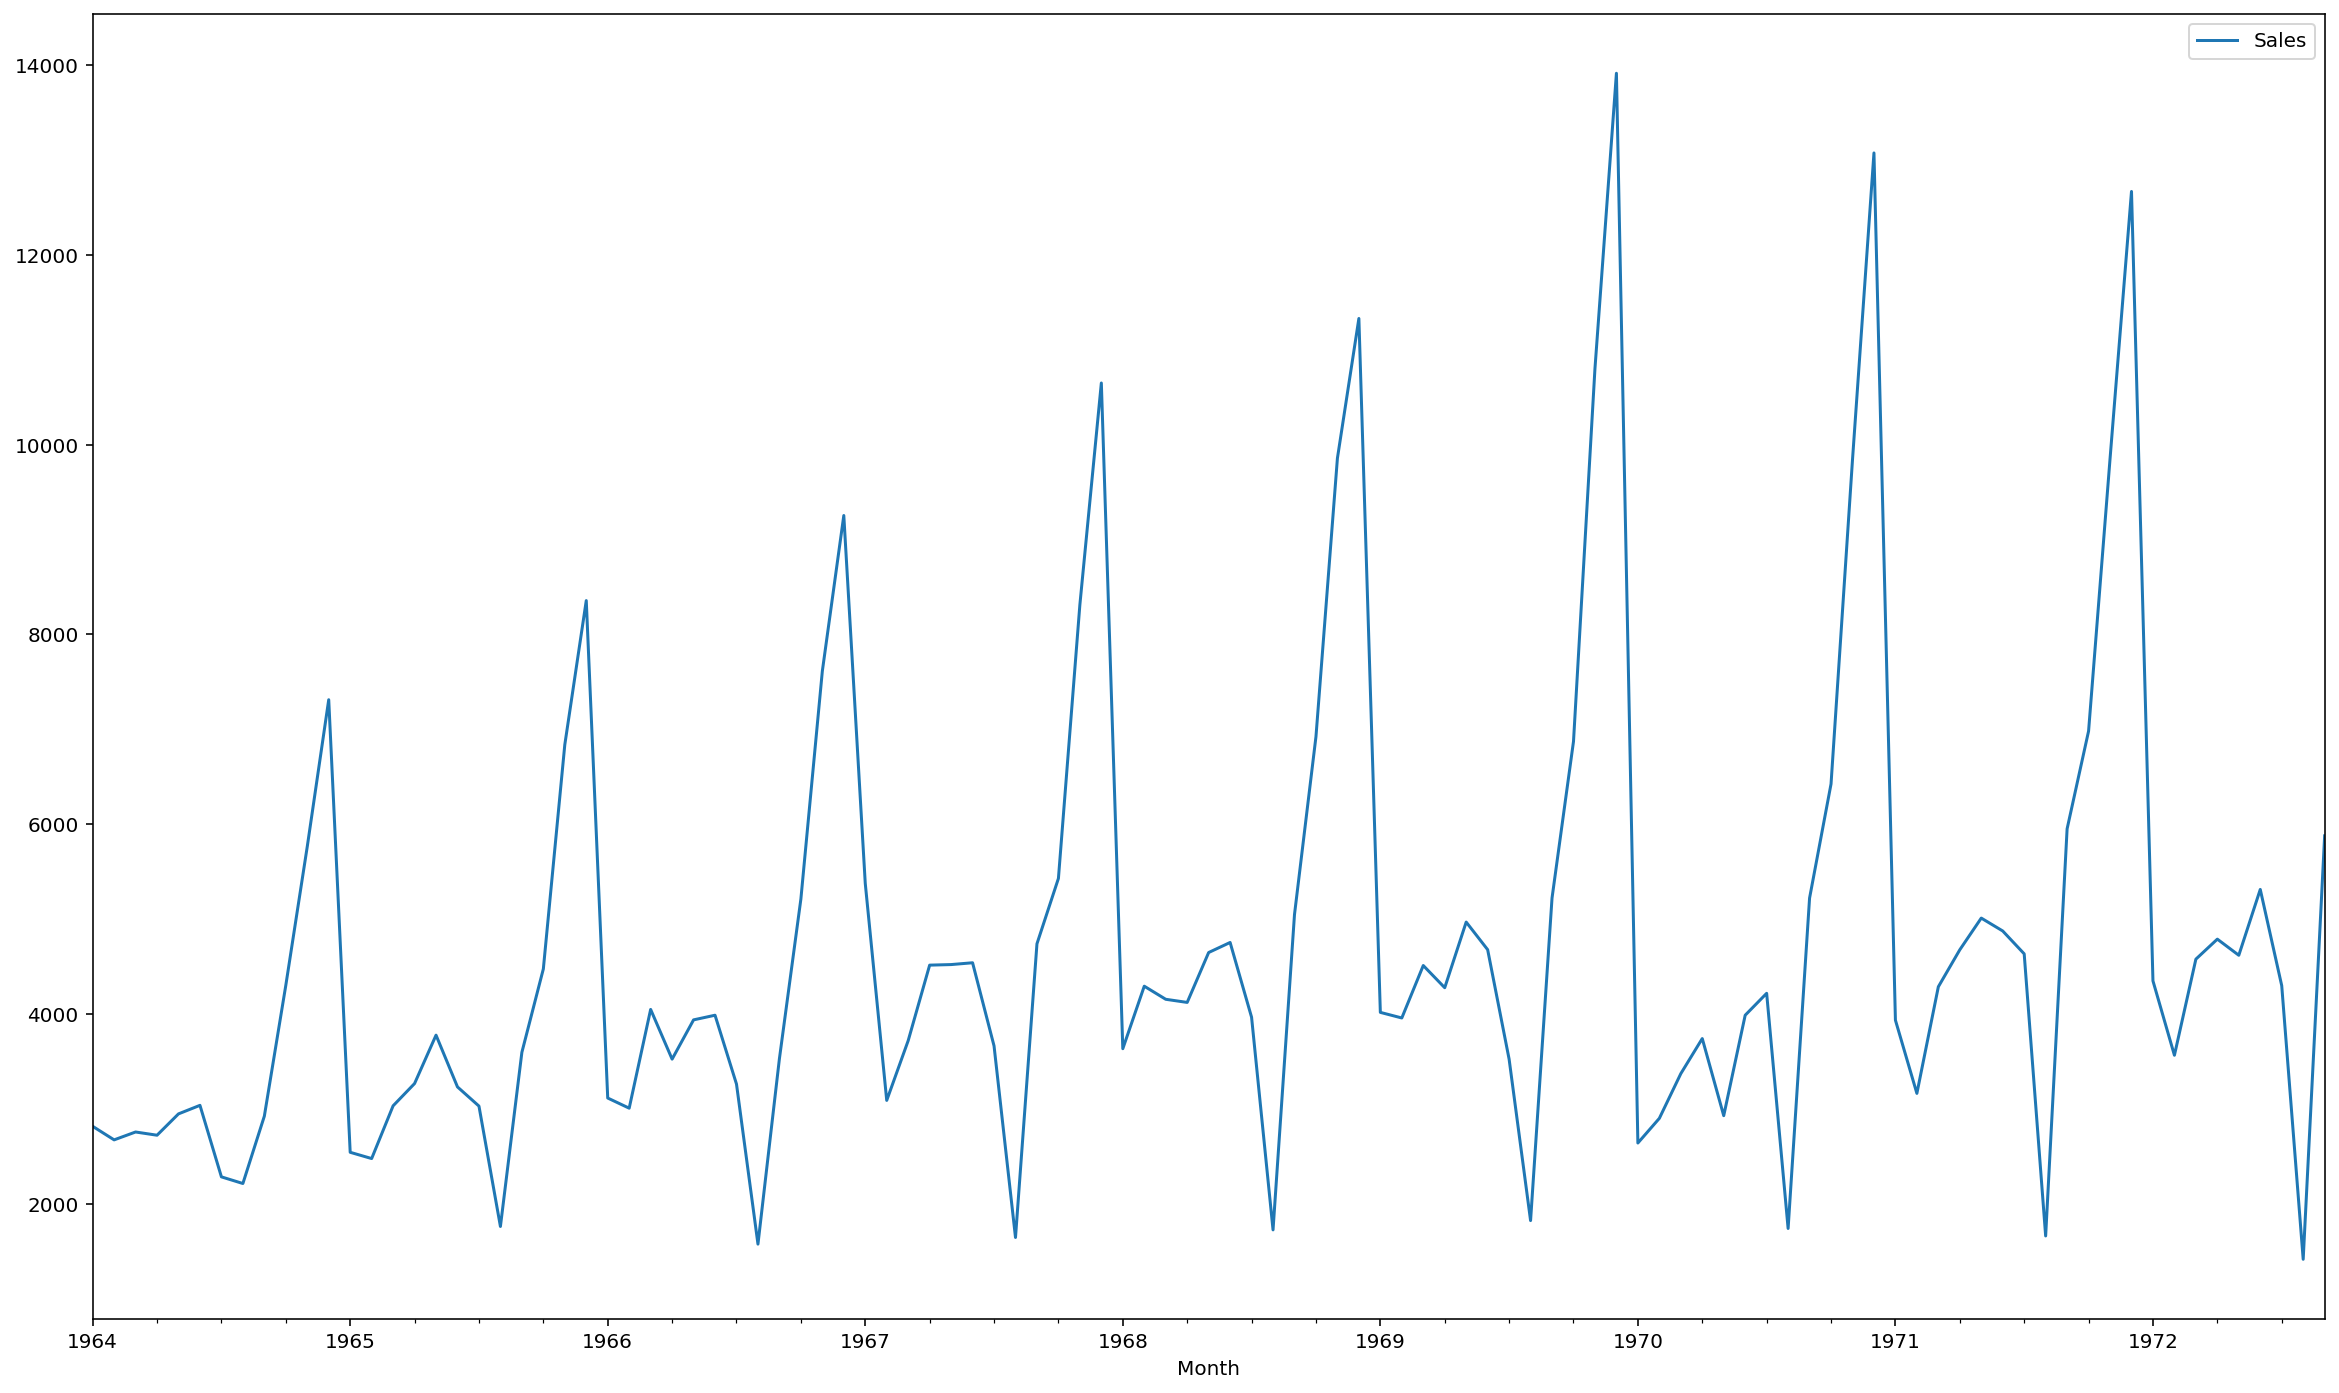

In [92]:
df.plot(figsize=(20, 12));

In [93]:
df.shape

(105, 1)

## Train/Test split

Разделяю выборку просто на две части. На тест оставляю последние 12 записей

In [105]:
N_test = 12

In [95]:
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [96]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

## Create model

In [97]:
hw = ExponentialSmoothing(
    train['Sales'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', 
    seasonal_periods=12 # тут по логике сезонный цикл 12 месяцев
)
results_hw = hw.fit()

In [98]:
df.loc[train_idx, 'Train Prediction'] = results_hw.fittedvalues
df.loc[test_idx, 'Test Prediction'] = results_hw.forecast(N_test)

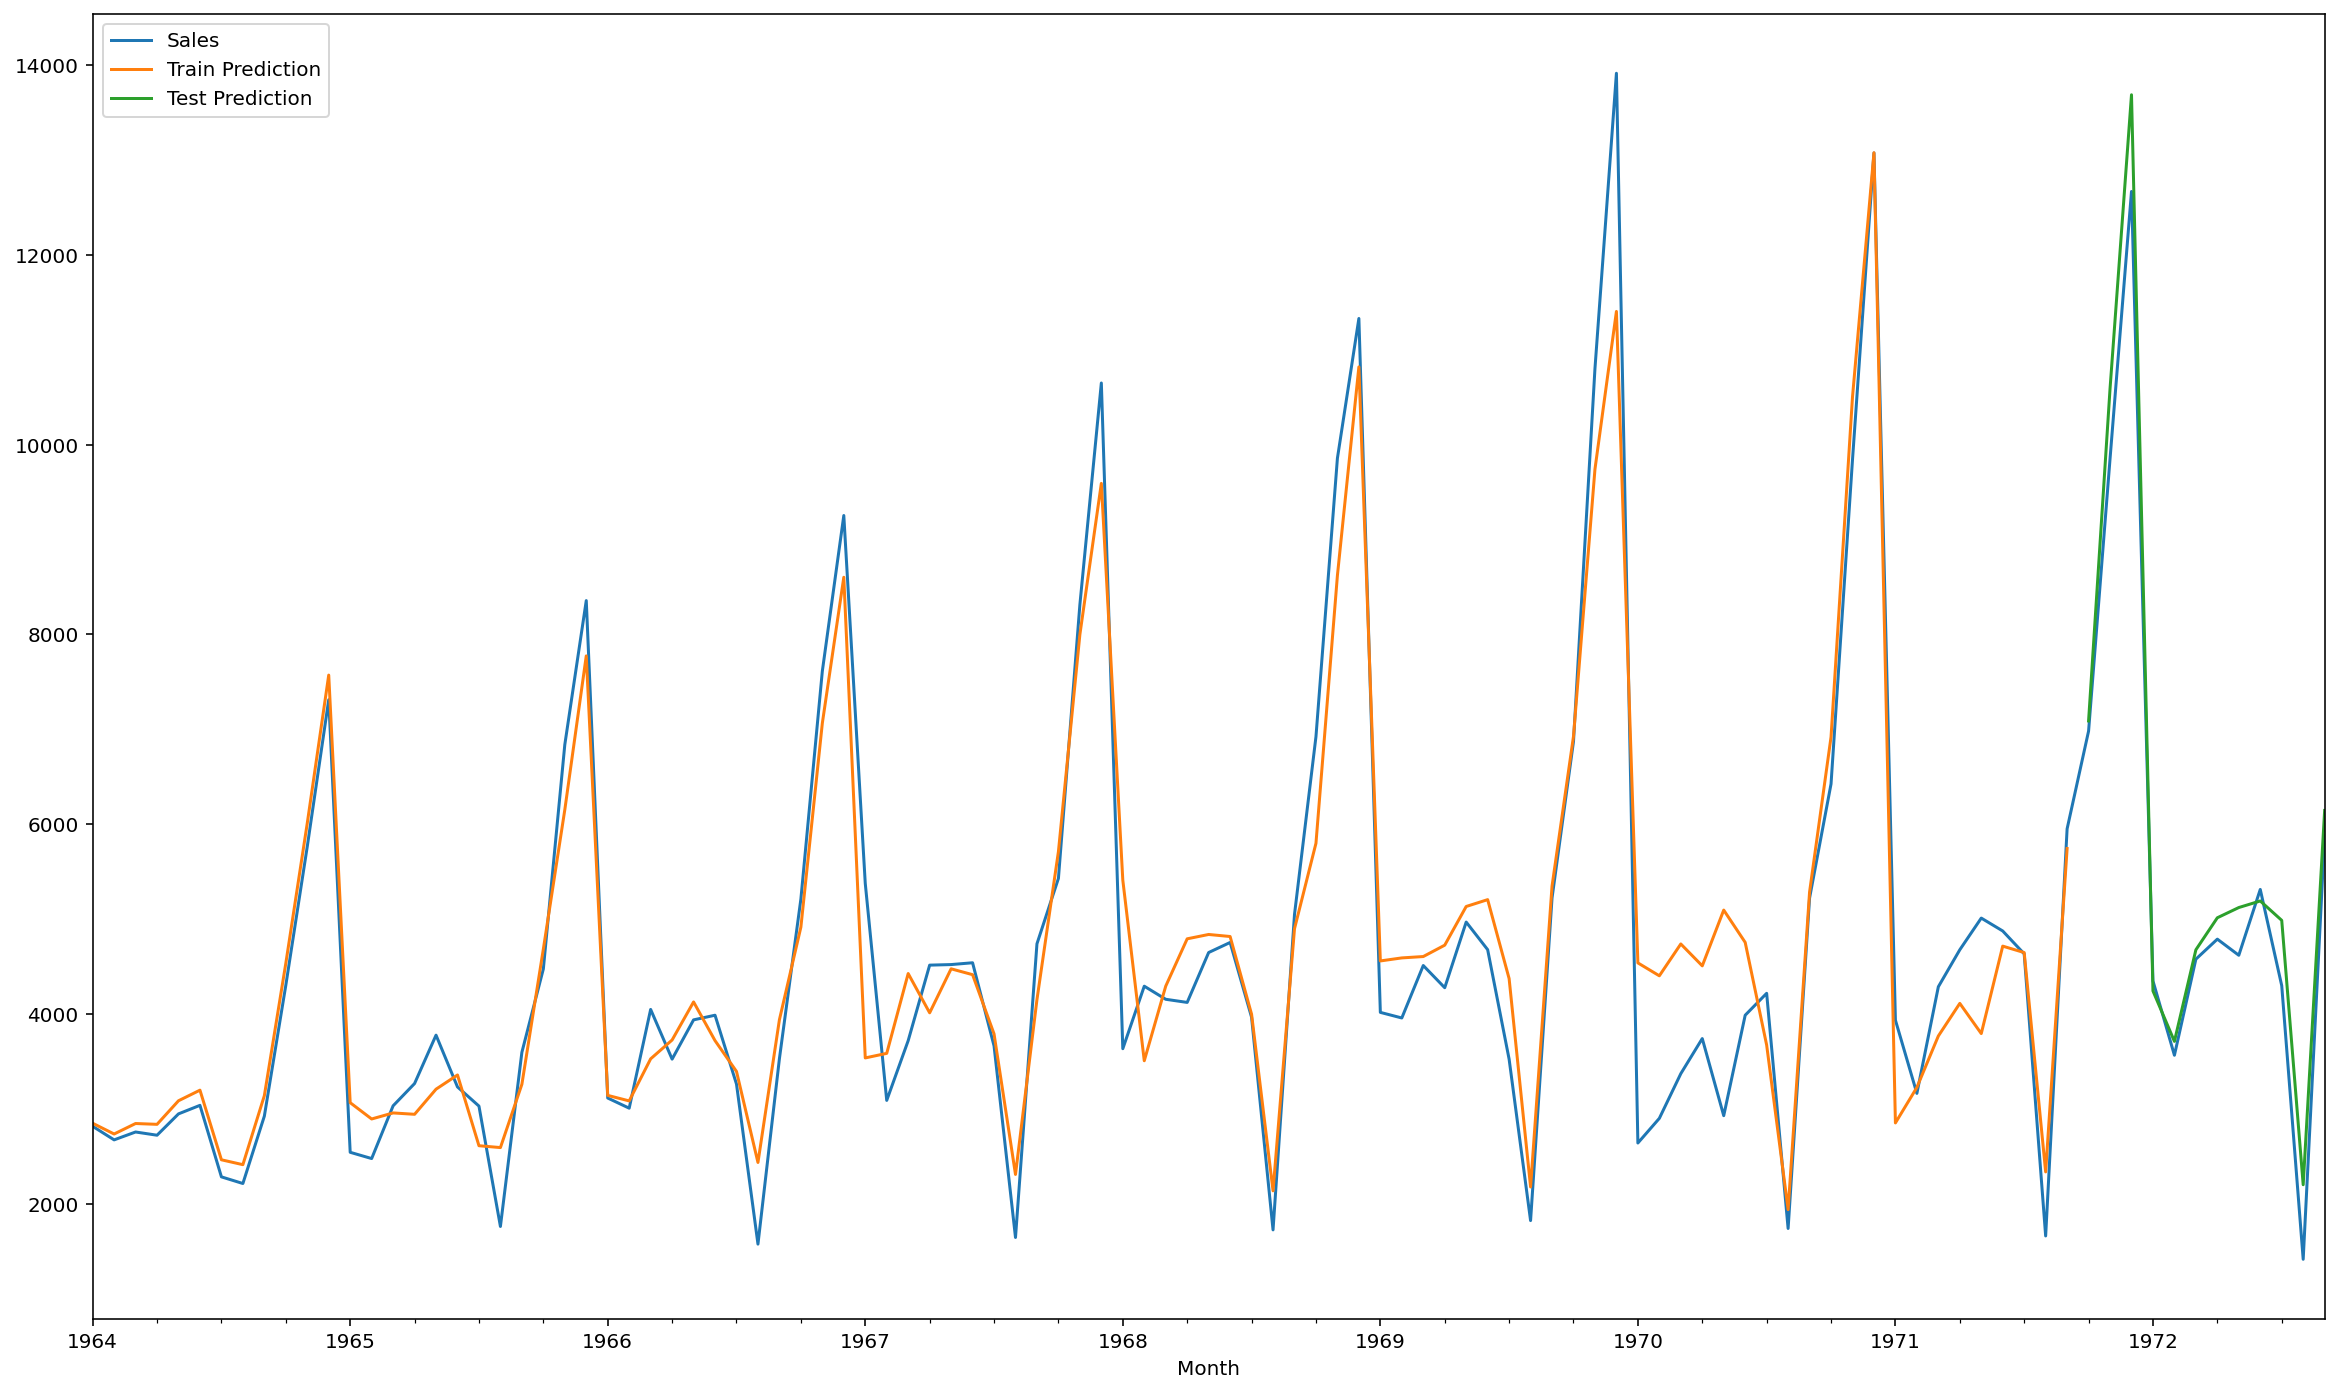

In [99]:
df.plot(figsize=(20, 12));

### Metrics

In [100]:
y_tain, y_test = train['Sales'], test['Sales']
y_tain_pred, y_test_pred = results_hw.fittedvalues, results_hw.forecast(N_test)

In [101]:
print(f'Train MAE: {mean_absolute_error(y_tain, y_tain_pred)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_test_pred)}')

Train MAE: 509.21382707970207
Test MAE: 400.7004521920696


In [102]:
print(f'Train RMSE: {mean_squared_error(y_tain, y_tain_pred, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False)}')

Train RMSE: 712.4708547120806
Test RMSE: 509.97414217426865


In [104]:
print(f'Train R2: {r2_score(y_tain, y_tain_pred)}')
print(f'Test R2: {r2_score(y_test, y_test_pred)}')

Train R2: 0.9169984903500262
Test R2: 0.9680340910154467
